In [1]:
import yaml
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

from src.data.prepare_data import prepare_data
from src.data.utils import resample_data
from src.models.model_selection import GridSearch, FeatureSelection
from src.models.classification import Classification
from src.models.evaluation import Evaluation

In [2]:
# read config
with open('config.yml', 'r') as file:
    config=yaml.load(file, Loader= yaml.SafeLoader)
del file

In [3]:
# load and prepare data
df = pd.read_csv(config['data_loader']['path'])
df = prepare_data(df=df)
display(df.head())
display(df['target'].value_counts(normalize=False))

# resample for imbalanced sets
df_sampled = resample_data(df=df, pos_share=0.01)
df_sampled['target'].value_counts(normalize=False)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,target
0,-0.260648,-0.469648,2.496266,-0.083724,0.129681,0.732898,0.519014,-0.130006,0.727159,0.637735,...,-0.110552,0.217606,-0.134794,0.165959,0.126280,-0.434824,-0.081230,-0.151045,17982.10,0
1,0.985100,-0.356045,0.558056,-0.429654,0.277140,0.428605,0.406466,-0.133118,0.347452,0.529808,...,-0.194936,-0.605761,0.079469,-0.577395,0.190090,0.296503,-0.248052,-0.064512,6531.37,0
2,-0.260272,-0.949385,1.728538,-0.457986,0.074062,1.419481,0.743511,-0.095576,-0.261297,0.690708,...,-0.005020,0.702906,0.945045,-1.154666,-0.605564,-0.312895,-0.300258,-0.244718,2513.54,0
3,-0.152152,-0.508959,1.746840,-1.090178,0.249486,1.143312,0.518269,-0.065130,-0.205698,0.575231,...,-0.146927,-0.038212,-0.214048,-1.893131,1.003963,-0.515950,-0.165316,0.048424,5384.44,0
4,-0.206820,-0.165280,1.527053,-0.448293,0.106125,0.530549,0.658849,-0.212660,1.049921,0.968046,...,-0.106984,0.729727,-0.161666,0.312561,-0.414116,1.071126,0.023712,0.419117,14278.97,0


target
0    284315
1    284315
Name: count, dtype: int64

target
0    281471
1      2843
Name: count, dtype: int64

In [4]:
# split dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    df_sampled.iloc[:,:-1], df_sampled['target']
    , test_size=config['model_selection']['test_set_size']
    , random_state=123
    , shuffle=True
    , stratify=df_sampled['target']
    )

# check the distribution of the target
print(y_train.value_counts(normalize=True), y_test.value_counts(normalize=True))

target
0    0.99
1    0.01
Name: proportion, dtype: float64 target
0    0.990011
1    0.009989
Name: proportion, dtype: float64


In [5]:
import numpy as np
from imblearn.under_sampling import RandomUnderSampler

# Assume X is the feature matrix and y is the target variable
undersampler = RandomUnderSampler(
    sampling_strategy='majority'
    , random_state=42
    )

X_train_rs, y_train_rs = undersampler.fit_resample(X_train, y_train)

# Check class distributions
print("Original class distribution:", np.bincount(y_train))
print("Resampled class distribution:", np.bincount(y_train_rs))

# split training set into multiple training sets
X_train_1, X_train_2, y_train_1, y_train_2 = train_test_split(
    X_train_rs, y_train_rs
    , test_size=0.5
    , random_state=123
    , shuffle=True
    , stratify=y_train_rs
    )

X_train_2, X_train_3, y_train_2, y_train_3 = train_test_split(
    X_train_2, y_train_2
    , test_size=0.5
    , random_state=123
    , shuffle=True
    , stratify=y_train_2
    )

print(
    "\ntrain 1 class distribution:", np.bincount(y_train_1)
    , "\ntrain 2 class distribution:", np.bincount(y_train_2)
    , "\ntrain 3 class distribution:", np.bincount(y_train_3)
    )

Original class distribution: [267397   2701]
Resampled class distribution: [2701 2701]

train 1 class distribution: [1350 1351] 
train 2 class distribution: [675 675] 
train 3 class distribution: [676 675]


In [6]:
# search best algorithm and hyperparams
grid_search = GridSearch(model_selection=config['model_selection'])
grid_search.fit(X=X_train_1, y=y_train_1)

for j in grid_search.results.keys():
    print(j, '-', grid_search.results[j]['best_score'])

c:\Users\gonpr\ML_Projects\Fraud\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\gonpr\ML_Projects\Fraud\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#l

LogisticRegression - 0.9526131306907647
DecisionTreeClassifier - 0.9515040733894707
RandomForestClassifier - 0.9522461833367564
XGBClassifier - 0.9718634901074827


In [7]:
# greedy feature selection
clf = Classification(
    algorithm=grid_search.best_algorithm
    , **grid_search.best_hyperparams
    )

feature_selection = FeatureSelection(X=X_train_2, y=y_train_2)
feats = feature_selection.wrapper(clf=clf, model_selection=config['model_selection'])
display(feats)

clf.fit(X=pd.concat([X_train_1, X_train_2])[feats], y=pd.concat([y_train_1, y_train_2]))

Index(['V4', 'V8', 'V10', 'V12', 'V14', 'V17', 'V22'], dtype='object')

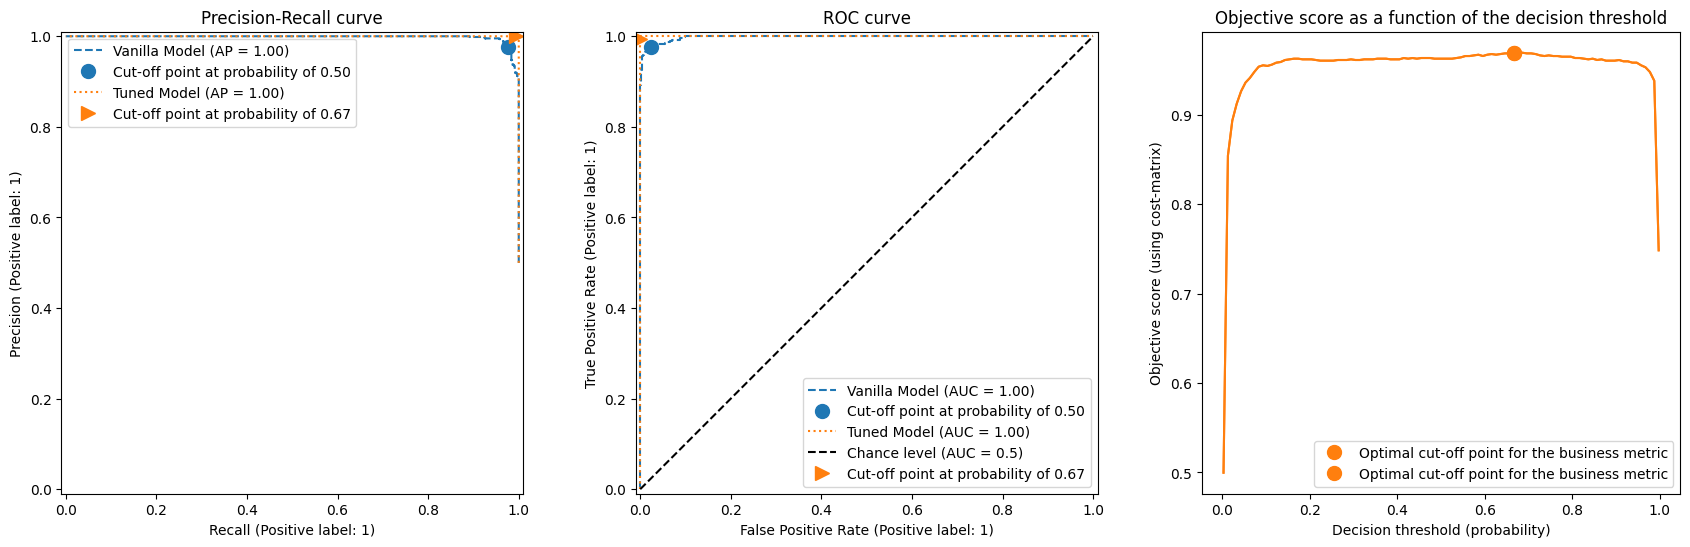

In [8]:
from src.models.model_selection import ClassificationThreshold
from src.visuals.pr_roc_curve import plot_roc_pr_curves

tuned_clf = ClassificationThreshold(model_selection=config['model_selection'])
tuned_clf.fit(clf=clf, X=X_train_3[feats], y=y_train_3)

plot_roc_pr_curves(clf.model, tuned_clf.model, X_train=X_train_3[feats], y_train=y_train_3)

In [11]:
# fit best algorithm on most important features of training data 
clf = Classification(
    algorithm=grid_search.best_algorithm
    , **grid_search.best_hyperparams
    )
clf.fit(X=X_train_rs[feats], y=y_train_rs)

# predict target value for the test set
y_pred = clf.predict(X_test[feats])
y_score = clf.score(X_test[feats])[:, -1]

y_pred_2 = np.where(y_score>=0.67, 1, 0)

In [12]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score
    , confusion_matrix
    )

print(
    f'accuracy: {accuracy_score(y_test, y_pred)}'
    , f'\naccuracy 2: {accuracy_score(y_test, y_pred_2)}'
    f'\n\nprecision: {precision_score(y_test, y_pred)}'
    , f'\nprecision 2: {precision_score(y_test, y_pred_2)}'
    f'\n\nrecall: {recall_score(y_test, y_pred)}'
    , f'\nrecall 2: {recall_score(y_test, y_pred_2)}'
    f'\n\nf1 score: {f1_score(y_test, y_pred)}'
    , f'\nf1 score 2: {f1_score(y_test, y_pred_2)}'
)

print(confusion_matrix(y_test, y_pred_2))

print('-'*5)
y_train_hat = np.where(clf.score(X_train_rs[feats])[:, -1]>=0.67, 1, 0)
print(
    f'accuracy: {accuracy_score(y_train_rs, y_train_hat)}'
    f'\nprecision: {precision_score(y_train_rs, y_train_hat)}'
    f'\nrecall: {recall_score(y_train_rs, y_train_hat)}'
    f'\nf1 score: {f1_score(y_train_rs, y_train_hat)}'
)

accuracy: 0.9844541361845808 
accuracy 2: 0.9905036578503095

precision: 0.38873239436619716 
precision 2: 0.5131086142322098

recall: 0.971830985915493 
recall 2: 0.9647887323943662

f1 score: 0.5553319919517102 
f1 score 2: 0.6699266503667481
[[13944   130]
 [    5   137]]
-----
accuracy: 0.9987041836356905
precision: 1.0
recall: 0.9974083672713809
f1 score: 0.9987025023169601


In [ ]:
eval = Evaluation(clf=clf)
eval.fit(X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)

In [ ]:
from src.visuals.boundary import plot_boundary

plot_boundary(
    X=X_train.iloc[:,[3,6,8]], y=y_train, clf=clf, azim=50, plot_points=True
)

In [ ]:
#pd.DataFrame({'score': y_score, 'label': y_pred}).groupby(by=['label']).describe()
#print(clf.model.decision_path(X_test[best_features[:2]].iloc[:10,:]))

In [ ]:
"""
https://medium.com/towards-data-science/tune-in-decision-threshold-optimization-with-scikit-learns-tunedthresholdclassifiercv-7de558a2cf58
https://scikit-learn.org/stable/auto_examples/model_selection/plot_cost_sensitive_learning.html#tunedthresholdclassifiercv-no-cv
https://scikit-learn.org/stable/modules/classification_threshold.html

overfitting

https://scikit-learn.org/stable/modules/learning_curve.html

feat select
# should feature selection be done before or after model selection?
# should it be trained on different dataset?
"""